<a href="https://colab.research.google.com/github/rojasgonzalezdavid777-code/GPX/blob/main/Copia_de_DAVIDRGPXUntitled6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install exif folium -q
import os, base64, folium
from exif import Image
from io import BytesIO
from PIL import Image as PILImage, ImageOps

In [ ]:
def convertir_a_decimal(coordenadas, ref):
    decimal = coordenadas[0] + coordenadas[1]/60 + coordenadas[2]/3600
    return -decimal if ref in ['S', 'W'] else decimal

def procesar_foto(ruta):
    """Endereza la foto y la convierte a Base64 para el mapa."""
    with PILImage.open(ruta) as img:
        img = ImageOps.exif_transpose(img) # Corrige rotación
        img.thumbnail((250, 250))          # Tamaño optimizado
        buf = BytesIO()
        img.save(buf, format="JPEG")
        return base64.b64encode(buf.getvalue()).decode()

In [ ]:
folder_path = "/content/drive/MyDrive/RUTA GPX"
archivos = sorted([f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg'))])


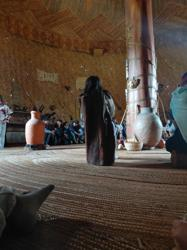
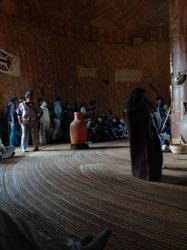
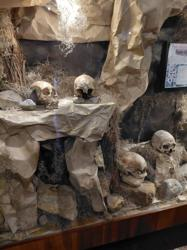
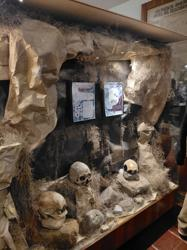
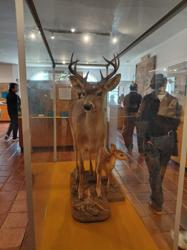
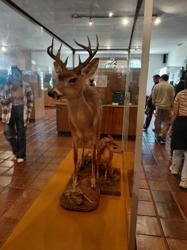
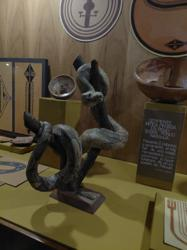
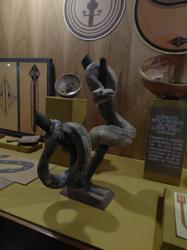
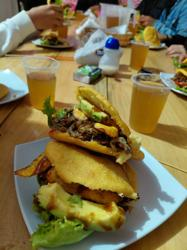
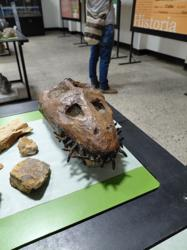

In [ ]:
miMapa = folium.Map(location=[0, 0], zoom_start=2)
puntos_ruta = []
primer_punto = True

for nombre in archivos:
    ruta_full = os.path.join(folder_path, nombre)
    try:
        with open(ruta_full, "rb") as f:
            img_exif = Image(f)

        if img_exif.has_exif and hasattr(img_exif, 'gps_latitude'):
            # 1. Coordenadas
            lat = convertir_a_decimal(img_exif.gps_latitude, img_exif.gps_latitude_ref)
            lon = convertir_a_decimal(img_exif.gps_longitude, img_exif.gps_longitude_ref)
            pos = [lat, lon]
            puntos_ruta.append(pos)

            # 2. Centrar mapa en la primera foto encontrada
            if primer_punto:
                miMapa.location, miMapa.zoom_start, primer_punto = pos, 16, False

            # 3. Preparar Imagen y Marcador
            img_b64 = procesar_foto(ruta_full)
            html = f'<div style="width:250px"><b>{nombre}</b><br>' \
                   f'<img src="data:image/jpeg;base64,{img_b64}" width="100%" style="border-radius:8px; margin-top:5px"></div>'

            folium.Marker(
                location=pos,
                popup=folium.Popup(html, max_width=270),
                icon=folium.Icon(color="red", icon="camera", prefix="fa")
            ).add_to(miMapa)

    except Exception as e:
        print(f"Saltando {nombre}: {e}")

# Dibujar la línea del recorrido
if len(puntos_ruta) > 1:
    folium.PolyLine(puntos_ruta, color="blue", weight=3, opacity=0.8).add_to(miMapa)

miMapa